In [1]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import os

import numpy as np
import pandas as pd
# from tsne import bh_sne
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
save_dir = './tsne_result'
batch_size = 128
seed = 1

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set seed
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)

# set dataset
# transform = transforms.Compose([    
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

image_height = 224

test_transforms = transforms.Compose([transforms.RandomResizedCrop(image_height),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])])

In [3]:
from torch.utils.data import DataLoader
import torchvision.datasets as dset

dataset = dset.ImageFolder(root='./data/test', transform = test_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4)

# set model
net = models.resnet34(pretrained=True)
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [7]:
def gen_features():
    net.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs = net(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(dataloader)):
                print(idx+1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs
import matplotlib.font_manager as fm
import matplotlib as mpl


def tsne_plot(save_dir, targets, outputs):
    print('generating t-SNE plot...')
    TNR = fm.FontProperties(fname='./font/times.ttf')
    # tsne_output = bh_sne(outputs)
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 40, 40
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("icefire", 120),
        data=df,
        marker='o',
        legend="full",
        alpha=1.0,
        s = 150
    )
    

    plt.xlabel('')
    plt.ylabel('')
    plt.legend()
    plt.title('t-SNE of Stanford Dog Dataset',  fontproperties = TNR, fontsize = 80)
    plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
    print('done!')


In [5]:
targets, outputs = gen_features()

10 / 32
20 / 32
30 / 32
32 / 32


generating t-SNE plot...
done!


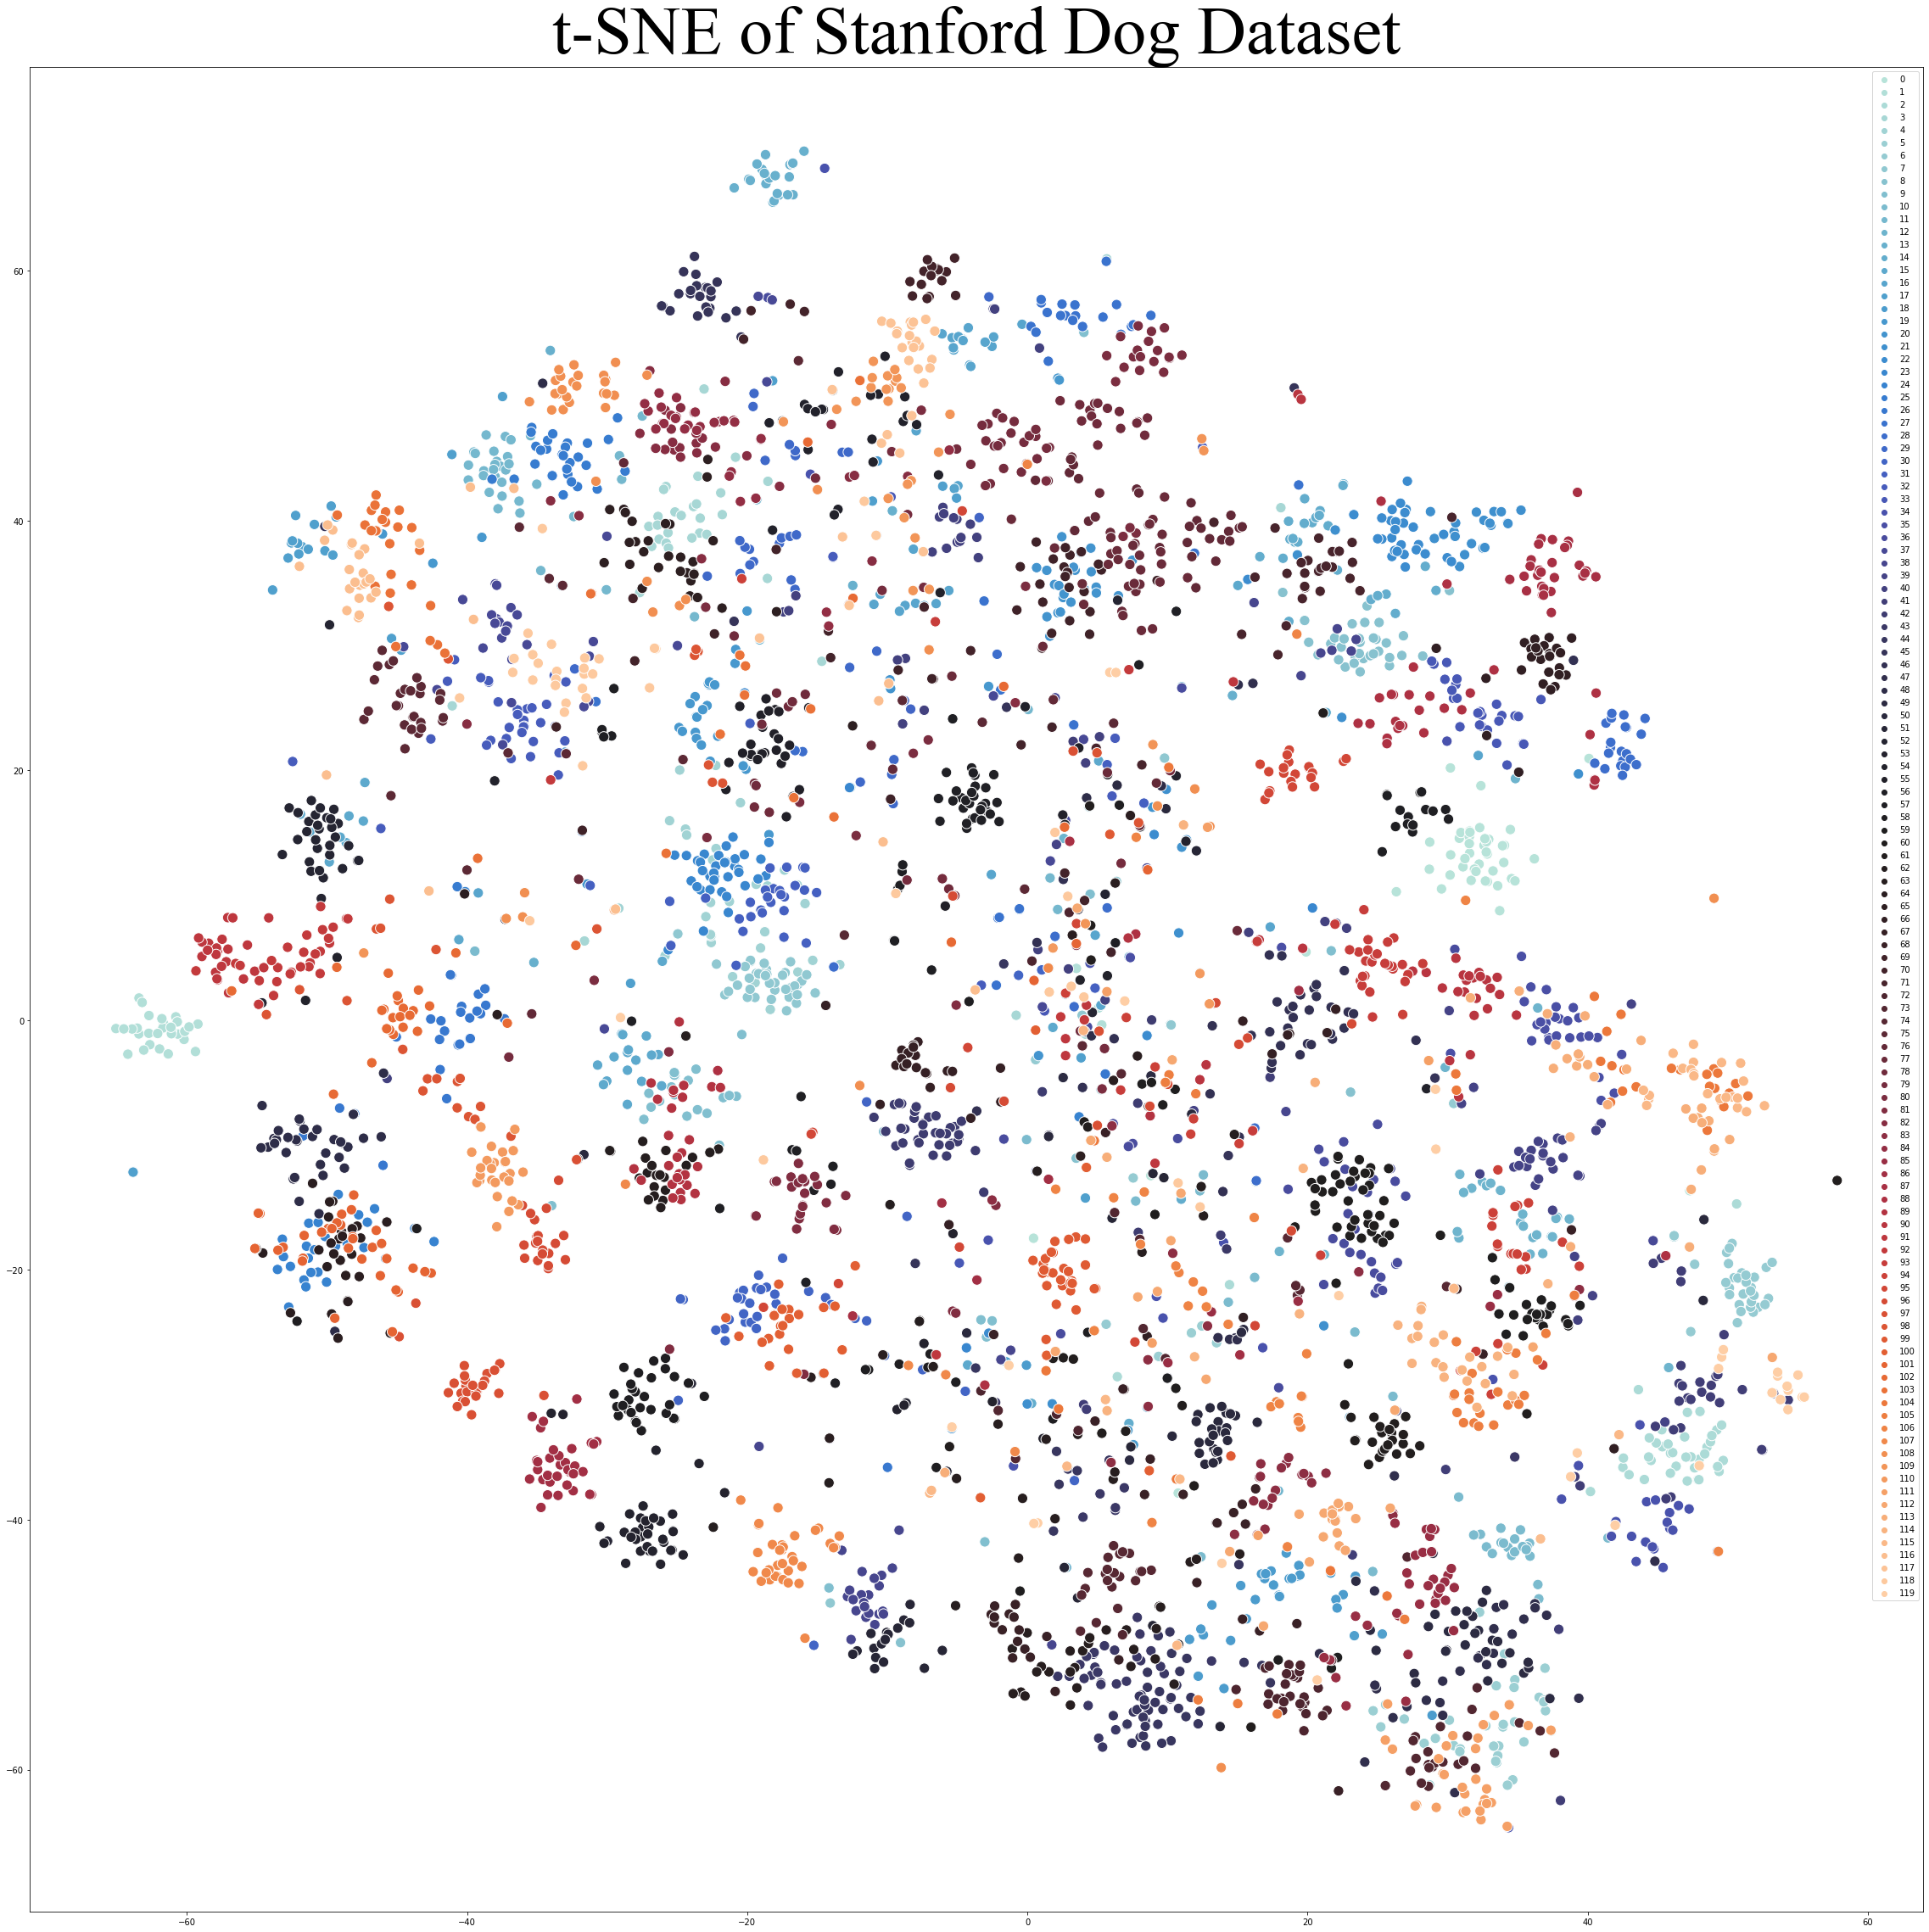

In [8]:
tsne_plot(save_dir, targets, outputs)